# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from art.utils import load_mnist
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.defences.preprocessor import TotalVarMin

# Load Data

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

# Train - Normal Model

In [7]:
normal_model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10)
])

In [8]:
normal_model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

In [9]:
normal_model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2195 - accuracy: 0.9346
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0916 - accuracy: 0.9711
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0648 - accuracy: 0.9794
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0499 - accuracy: 0.9836
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0362 - accuracy: 0.9881
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0322 - accuracy: 0.9892
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0276 - accuracy: 0.9904
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0228 - accuracy: 0.9924
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0197 - accuracy: 0.9936
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.019

# Fast Gradient Method Attack

In [10]:
art_model = TensorFlowV2Classifier(
    model=normal_model, 
    loss_object=CategoricalCrossentropy(from_logits=True), 
    nb_classes=10, 
    input_shape=(28, 28), 
    clip_values=(0, 1)
)

In [11]:
fgsm = FastGradientMethod(estimator=art_model, eps=0.1)

In [12]:
adv_train = fgsm.generate(x=x_train)

In [13]:
adv_test = fgsm.generate(x=x_test)

# Total Variance Minimization

In [14]:
tv_minimization = TotalVarMin(clip_values=(min_, max_))

In [15]:
def_train, _ = tv_minimization(adv_train, y_train)

In [16]:
def_test, _ = tv_minimization(adv_test, y_test)

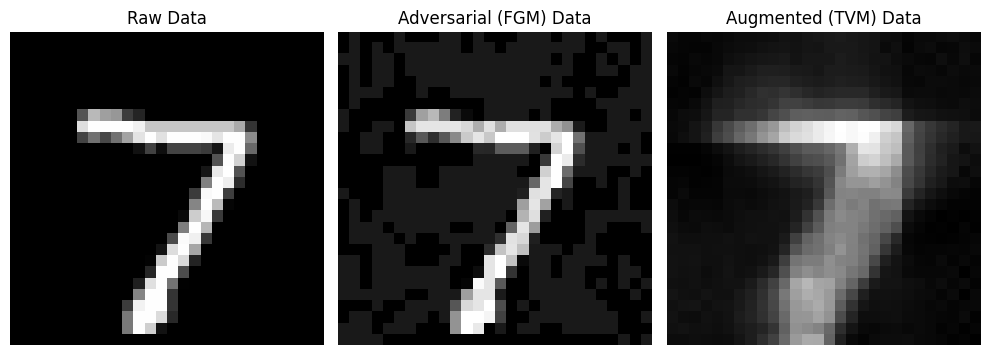

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))

axes[0].imshow(x_test[0], cmap="gray")
axes[0].axis("off")
axes[0].set_title("Raw Data")

axes[1].imshow(adv_test[0], cmap="gray")
axes[1].axis("off")
axes[1].set_title("Adversarial (FGM) Data")

axes[2].imshow(def_test[0], cmap="gray")
axes[2].axis("off")
axes[2].set_title("Augmented (TVM) Data")

plt.tight_layout()
plt.show()

# Train - Augmented Model

In [18]:
augmented_model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10)
])

In [19]:
augmented_model.compile(loss=CategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

In [20]:
augmented_model.fit(def_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.4386 - accuracy: 0.8616
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2125 - accuracy: 0.9347
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1644 - accuracy: 0.9497
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1380 - accuracy: 0.9566
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1196 - accuracy: 0.9634
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1081 - accuracy: 0.9667
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0981 - accuracy: 0.9697
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0891 - accuracy: 0.9722
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0826 - accuracy: 0.9742
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.077

# Results

In [21]:
y_test = np.argmax(y_test, axis=1)

In [22]:
normal_preds = np.argmax(normal_model.predict(adv_test), axis=1)

313/313 [==============================] - 0s 1ms/step


In [23]:
augmented_preds = np.argmax(augmented_model.predict(adv_test), axis=1)

313/313 [==============================] - 0s 1ms/step


In [24]:
print("Normal Model Accuracy Score on Adversarial (FGM) Data:", accuracy_score(y_test, normal_preds))
print("Augmented Model Accuracy Score on Adversarial (FGM) Data:", accuracy_score(y_test, augmented_preds))

Normal Model Accuracy Score on Adversarial (FGM) Data: 0.306
Augmented Model Accuracy Score on Adversarial (FGM) Data: 0.8346
